# Read PSL motion files

Clues:
```
04/28/2024 00:00 systron PSL (SN: 999)
0000009 0.002179841,-0.004321344,-0.007393281,0.1804913,-0.09683202,-3.639365,1
0000119 -0.002570751,-0.005,-0.002642688,0.01625653,-0.07443636,-3.662439,1
0000213 -0.002570751,-0.005,-0.0101079,0.008791309,-0.0181079,-3.700444,1
0000305 -0.01071462,-0.006357312,-0.005357312,-0.04889446,0.05382964,-3.749306,1

1 time
2 accx (m.s^-^2)
3 accy (m.s^-^2)
4 accz (m.s^-^2)
5 ratex (rad/s)
6 ratey (rad/s)
7 ratez (rad/s)
```

In [2]:
# usings

using Pkg; Pkg.activate(".")
using Dates
using Printf
using PyPlot

  Activating project at `~/Projects/ASTRAL/mast`


In [3]:
# usings

using Pkg; Pkg.activate(".")
using Dates
using Printf
using PyPlot

  Activating project at `~/Projects/ASTRAL/mast`


In [4]:
# general PSL DAS readers

# utility functions
m2n(x) = ismissing(x) ? NaN : x
pd = permutedims

# parameters for ASTRAL - feed defaults to functions
baseyear = 2024
mastdir = "./data/PSL/"
# ncolumn = 22 # change for different file types

"yearday from Date or DateTime"
yday(dt) = Dates.value(Date(dt) - Date(year(dt)-1,12,31))
yday(ddd::String) = parse(Int, ddd)

"return all filenames with prefix and date dt"
function get_das_filenames(prefix, yd::Integer, mastdir=mastdir)
    filter(startswith(prefix), 
           readdir(joinpath(mastdir, @sprintf("%03d",yd))))
end
function get_das_filenames(prefix, dt::Date, mastdir=mastdir)
    get_das_filenames(prefix, yday(dt), mastdir)
end
"return filenames with prefix matching hour of dt"
function get_das_filenames(prefix, dt::DateTime, mastdir=mastdir)
    hh = @sprintf("%02d", Dates.value(Hour(dt)))
    filter( endswith(hh*"_raw.txt"),
            get_das_filenames(prefix, Date(dt), mastdir) )
end

"return vector of full paths of all files with prefix and date"
function get_das_pathfiles(prefix, dt, mastdir=mastdir)
    joinpath.(mastdir,
              @sprintf("%03d",yday(dt)),
              get_das_filenames(prefix, dt, mastdir))
end

"Convert a PSL date to a DateTime."
function psldatetime(d::Date, hr::Integer, psltime::AbstractString)
    mm  = Minute(     parse(Int32, psltime[1:2]))
    SS  = Second(     parse(Int32, psltime[3:4]))
    sss = Millisecond(parse(Int32, psltime[5:7]))
    DateTime(Date(d)) + Hour(hr) + mm + SS + sss
end
function psldatetime(d::Date, hr::Integer=0, minute::Real=0)
    DateTime(Date(d)) + Hour(hr) + Minute(minute) + Second(second)
end
function psldatetime(yearday::Integer, hr::Integer=0; minute::Real=0, year=baseyear)
    DateTime(year,12,31) + Day(yearday) + Hour(hr) + Minute(minute)
end
# psldatetime(Date(2024,5,8), hr, "0606111")
# To get filename from the date, hour
# psldatefile(prefix, psldatetime(d, hr, psltime))

# file format default parameters
nheader = 1
# dt = DateTime(2024,5,8,11,0,0)
# pathfilename = get_das_pathfiles(prefix, dt::DateTime, mastdir=mastdir)

"read das data and put in a dictionary"
function read_das_dict(pathfilename, keys;
    nheader=nheader,
    nsample=sum(countlines.(pathfilename) .- nheader),
    ncolumn=length(keys)-1 ) # default columns in data excluding datestamp

    # read data from file
    datatime, X = read_das_data(pathfilename; 
        nheader=nheader,
        nsample=nsample,
        ncolumn=ncolumn ) # specifying manages memory best
    
    return das_dict(keys, datatime, X) # returns dict
end

parseblank2missing(T, s) = isempty(s) ? missing : parse(T, s)

"read and parse one file"
function read_das_data(pathfilename::AbstractString;
    nheader=1, 
    nsample=countlines(pathfilenames) - nheader, 
    ncolumn=22 )

    # trivially iterate over 1-vector
    dt, X = read_scs_data(pathfilename[1:1]; 
        nheader=nheader, nsample=nsample, ncolumn=ncolumn )
    return dt, X
end

"read and concatenate data from multiple files"
function read_das_data(pathfilename::Vector{<:AbstractString};
    nheader=1,
    nsample=sum( countlines.(pathfilenames) - nheader ),
    ncolumn=26 ) # data, not including timestamp

    # preallocate the data
    # psltime = Vector{String}(undef, nsample) # will point to data as it is read
    psldt = Vector{DateTime}(undef, nsample) # will point to data as it is read
    X = Array{Union{Float32,Missing}, 2}(undef, nsample, ncolumn)
    fill!(X, missing)

    nl = 0
    maxcol=0
    for pfile in pathfilename
        # find hour from the filename
        shortfilename = last(splitpath(pfile))
        ddd = shortfilename[end-12:end-10]
        basedt = Date(baseyear-1,12,31) + Day(yday(ddd))
        hr = parse(Int32, shortfilename[end-9:end-8])

        open(pfile) do file
            for _ in 1:nheader
                readline(file) # skip header
            end
            for line in readlines(file)
                nl += 1
                splt = split(line, r"[\s,]+")

                nx = min(ncolumn, length(splt[2:end]))
                if nx > 0 # skip empty lines
                    psltime = splt[1]
                    psldt[nl] = psldatetime(basedt, hr, psltime)

                    dataline = try
                        parseblank2missing.(Float32, splt[2:end])
                    catch
                        error("failed to parse: $(splt[2:end])")
                    end
                    maxcol = max(maxcol, nx) # data in longest line

                    # X[nl, 1:nx] .= cat(lat,lon,dataline[1:nx], dims=1)
                    X[nl, 1:nx] .= dataline[1:nx]
                end
            end
        end
    end

    return psldt[1:nl], X[1:nl, 1:maxcol]
end

# Dicts are just mutable groups bound to data.
# Data in dictionaries don't need to be allocated.

"assign data to a dict of keys"
function das_dict(keys, datatime, X)
    D = Dict{eltype(keys), Any}()

    # special DateTime
    D[keys[1]] = datatime 
    # fill rest of dictionary
    for (ik, ky) in enumerate(keys[2:end])
        D[ky] = X[:, ik]
    end
    return D
end

"compute the decimal hour of day from a datetime"
function decimal_hour(dt::DateTime)::Float64
    hour = Dates.hour(dt)
    minute = Dates.minute(dt)
    second = Dates.second(dt)
    millisecond = Dates.millisecond(dt)
    
    # Calculate the decimal hour
    decimal_hour = hour + minute / 60 + second / 3600 + millisecond / 3600000
    return decimal_hour
end

decimal_hour

In [5]:
motkeys = Symbol.(split("""time
    accx
    accy
    accz
    ratex
    ratey
    ratez"""))

7-element Vector{Symbol}:
 :time
 :accx
 :accy
 :accz
 :ratex
 :ratey
 :ratez

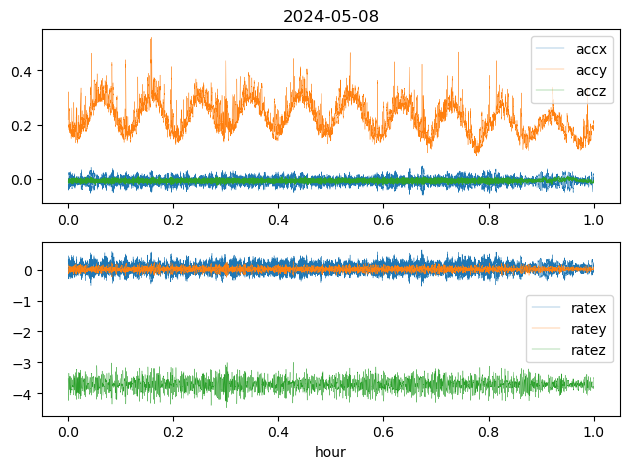

In [25]:
dt = DateTime(2024,5,8,0,0,0)
Mot = read_das_dict(get_das_pathfiles("mot", dt), motkeys; ncolumn=length(motkeys)-1)
dh = m2n.(decimal_hour.( Mot[:time] ))
dtf = Dates.format(Mot[:time][5], dateformat"yyyy-mm-dd")

clf
subplot(2,1,1)
for k in [:accx, :accy, :accz]
    plot(dh, Mot[k], label=String(k), linewidth=0.25)
end
legend(frameon="false")
title(dtf)

subplot(2,1,2)
for k in [:ratex, :ratey, :ratez]
    plot(dh, Mot[k], label=String(k), linewidth=0.25)
end
legend(frameon="false")
xlabel("hour")

tight_layout()